In [1]:
import cv2
import numpy as np
import os.path as op
import matplotlib.pyplot as plt

In [2]:
data_path = op.join('.', 'images', 'test2')
img_type = '.JPG'
img_set = []
exposure_time = []

In [3]:
def imshow(img, cmap=None):
    plt.imshow(img, cmap)
    plt.show()

./images/test2/IMG_0692.JPG
0.016666666666666666


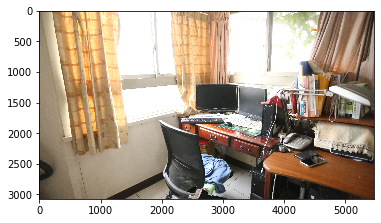

./images/test2/IMG_0693.JPG
0.0125


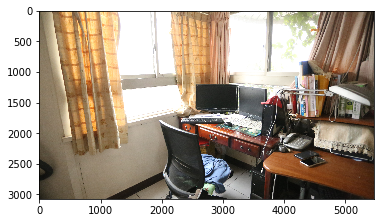

./images/test2/IMG_0694.JPG
0.01


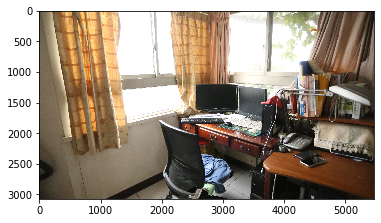

./images/test2/IMG_0695.JPG
0.008


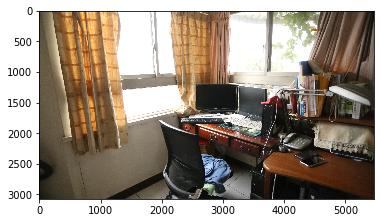

./images/test2/IMG_0696.JPG
0.00625


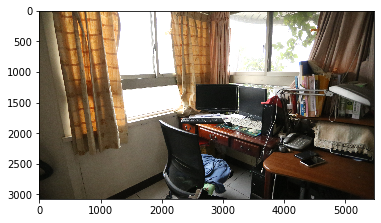

./images/test2/IMG_0697.JPG
0.005


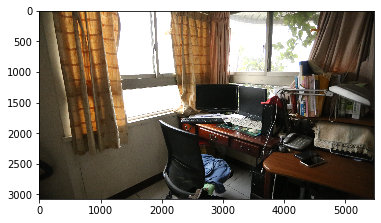

./images/test2/IMG_0698.JPG
0.004


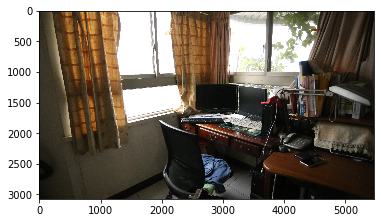

./images/test2/IMG_0699.JPG
0.003125


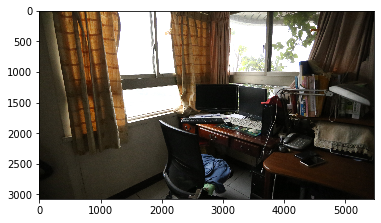

./images/test2/IMG_0700.JPG
0.0025


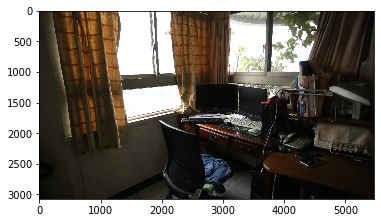

./images/test2/IMG_0701.JPG
0.002


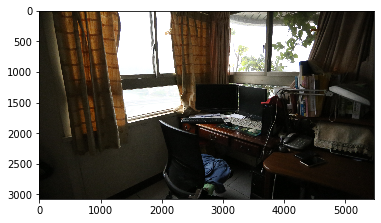

./images/test2/IMG_0702.JPG
0.0015625


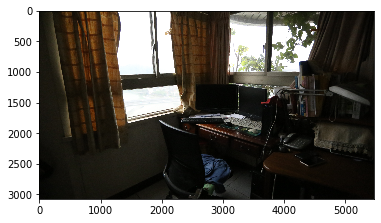

./images/test2/IMG_0703.JPG
0.00125


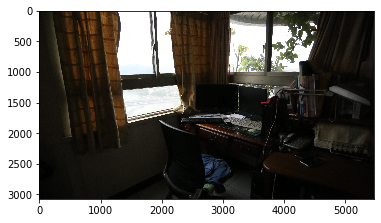

./images/test2/IMG_0704.JPG
0.001


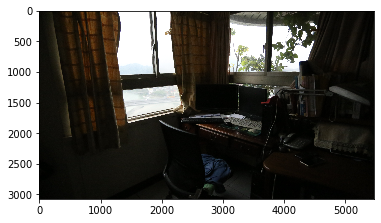

./images/test2/IMG_0705.JPG
0.0008


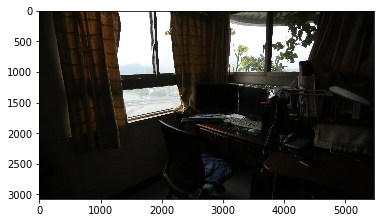

./images/test2/IMG_0706.JPG
0.000625


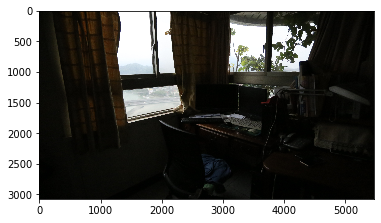

./images/test2/IMG_0707.JPG
0.0005


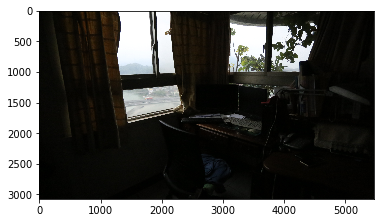

./images/test2/IMG_0708.JPG
0.0004


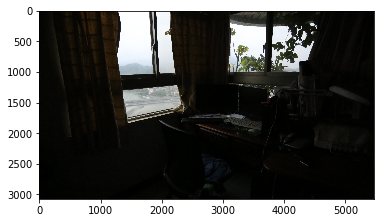

./images/test2/IMG_0709.JPG
0.0003125


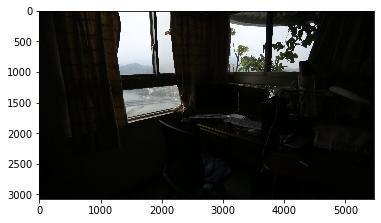

./images/test2/IMG_0710.JPG
0.00025


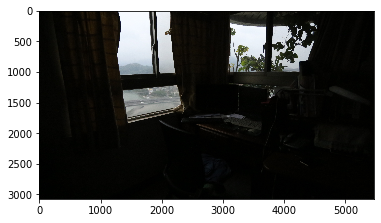

3072 5472 3


In [4]:
img_set.clear()
exposure_time.clear()

with open(op.join(data_path, 'shutter_speed.csv'), 'r') as fp:
    lines = fp.readlines()

    for line in lines:
        filename, shutter_speed = line.split(', ')
        shutter_speed = int(shutter_speed)

        # exposure time
        exp_t = 1/shutter_speed
        exposure_time.append(exp_t)

        # read image
        filepath = op.join(data_path, filename + img_type)
        img = cv2.imread(filepath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_set.append(img)

        # display data
        print(filepath)
        print(exp_t)
        imshow(img)
        
img_set = np.array(img_set)

# parameters
num_imgs = len(img_set)
height, width, channels = img_set[0].shape
print(height, width, channels)


## Sample Pixel
Select pixels for recovering response curve.

In [5]:
num_pixels = 50
# sampled pixels
# should be in shape channels x num_pixels x num_imgs
sampled_pixels = np.array([])

# check if the number of pixels is enough to recover the response curve 
if num_pixels * (num_imgs-1) < 256:
    print('The number of pixels is not enough!')

In [6]:
# Random Sample
x_coords = np.random.randint(0, height, (num_pixels, 1))
y_coords = np.random.randint(0, width, (num_pixels, 1))
coords = np.concatenate((x_coords, y_coords), axis=1)
print(coords)

sampled_pixels = [[[img_set[j][coords[i, 0], coords[i, 1]][c] for j in range(num_imgs)] for i in range(num_pixels)] for c in range(channels)]
sampled_pixels = np.array(sampled_pixels)

print(np.shape(sampled_pixels))

[[1176 1748]
 [ 308  109]
 [  18  883]
 [1164 1748]
 [1705   99]
 [ 257 3593]
 [2647 4714]
 [1211 3829]
 [ 147 4713]
 [ 703 4152]
 [ 930 1257]
 [2328   84]
 [ 630 4516]
 [1690 3199]
 [1791 2230]
 [1332 5005]
 [ 998 2882]
 [1947 2868]
 [2351 4883]
 [ 855 1508]
 [ 350 1291]
 [2661 2807]
 [2852 5005]
 [1951  781]
 [1820 4553]
 [1718 1419]
 [1610  364]
 [2704 1801]
 [2883 5065]
 [ 319  353]
 [1045  229]
 [2700  525]
 [ 594 4802]
 [ 946   73]
 [ 458 1437]
 [ 164 4501]
 [1074 1162]
 [1890 4199]
 [1850 1099]
 [2869 1502]
 [2235 2187]
 [ 336 2129]
 [2298 2733]
 [1085 2464]
 [2224 2644]
 [1258 4253]
 [1925 1697]
 [2725 4741]
 [  15 2755]
 [ 640 4967]]
(3, 50, 19)


## Solve Response Curve 

(3, 256)


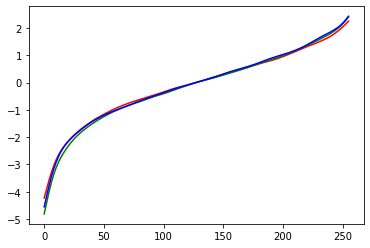

In [7]:
# Optimization
# response curve

def gsolve(Z, B, l, w):
    '''
    Assumes:
        Zmin = 0
        Zmax = 255

    Arguments:
        Z(c, i, j): sample pixel values at position i in image j of channel c
        B(j): log delta t(exprosure time) of image j
        l: lambda, weighting regression term
        w(z): weighting function

    Returns:
        g(c, z): log exprosure ccorresponding to pixel value z of chammel c
        lE(c, i): log irradiance at pixel position i of channel c
    '''

    g = []
    # lE = []

    # parameters
    n = 256 # intensity range
    channels, num_pixels, num_imgs = np.shape(Z)

    for c in range(channels):

        A = np.zeros((num_pixels * num_imgs + n + 1, n + num_pixels))
        b = np.zeros((A.shape[0], 1))

        k = 1 # current row of A
        for i in range(num_pixels):
            for j in range(num_imgs):
                # weight of current intensity
                wij = w[Z[c, i, j]]

                A[k, Z[c, i, j]] = wij
                A[k, n + i] = -wij
                b[k] = wij * B[j]

                k += 1

        # restrict 127 to be 0
        A[k, 127] = 1
        k += 1

        # smoothness term
        for i in range(n-2):
            lw = l * w[i+1]

            A[k, i] = lw
            A[k, i+1] = -2 * lw
            A[k, i+2] = lw

            k += 1
        
        # least-square solution for linear matrix equation
        x = np.linalg.lstsq(A, b, rcond=None)[0]
        g.append(x[:n])
        # lE.append(x[n+1:])

    return np.reshape(g, (channels, n))

# log exprosure time
ln_exp_time = np.log(exposure_time)
# hat weighting function
Zmin = 0
Zmax = 255
Zmed = (Zmin + Zmax)/2
hat_weight = np.array([z-Zmin if z <= Zmed else Zmax-z for z in range(256)])/int(Zmed)

g = gsolve(sampled_pixels, ln_exp_time, 30, hat_weight)
print(g.shape)

# plot
plt.plot(g[0], color='r')
plt.plot(g[1], color='g')
plt.plot(g[2], color='b')
plt.show()

In [10]:
# Construct Radiance Map
def HDR(Z, B, g, w):

    num_imgs, height, width, channels = np.shape(Z)
    lE = np.zeros((channels, height, width))

    '''
    # move axis version
    mZ = np.moveaxis(Z, [0, 3], [3, 0])
    for c in range(channels):
        wij = w[mZ[c]]
        lE[c] = np.sum(wij*(g[c, mZ[c]]-B), axis=-1) / np.sum(wij, axis=-1)
    
    '''
    # loop version
    progress = '0%'
    
    for c in range(channels):
        for x in range(height):
            for y in range(width):
                wij = w[Z[:, x, y, c]]
                lE[c, x, y] = np.sum(wij * (g[c, Z[:, x, y, c]] - B)) / np.sum(wij)
            
            # display progress
            new_prog = '{}%'.format(int((c*height + x)/(channels*height) * 100))
            if new_prog != progress:
                progress = new_prog
                print(progress)
    

    return lE

radiance_map = HDR(img_set, ln_exp_time, g, hat_weight)
print(radiance_map.shape)

1%
2%
3%
4%
5%
6%
7%
8%
9%
10%
11%
12%
13%
14%
15%
16%
17%
18%
19%
20%
21%
22%
23%
24%
25%
26%
27%
28%
29%
30%
31%
32%
33%
34%
35%
36%
37%
38%
39%
40%
41%
42%
43%
44%
45%
46%
47%
48%
49%
50%
51%
52%
53%
54%
55%
56%
57%
58%
59%
60%
61%
62%
63%
64%
65%
66%


<ipython-input-10-048659c3b82d>:22: RuntimeWarning: invalid value encountered in double_scalars
  lE[c, x, y] = np.sum(wij * (g[c, Z[:, x, y, c]] - B)) / np.sum(wij)


67%
68%
69%
70%
71%
72%
73%
74%
75%
76%
77%
78%
79%
80%
81%
82%
83%
84%
85%
86%
87%
88%
89%
90%
91%
92%
93%
94%
95%
96%
97%
98%
99%
(3, 3072, 5472)


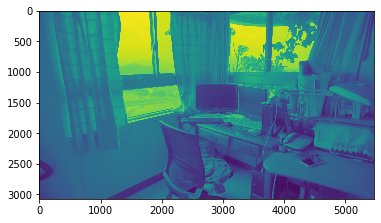

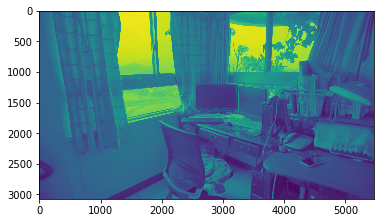

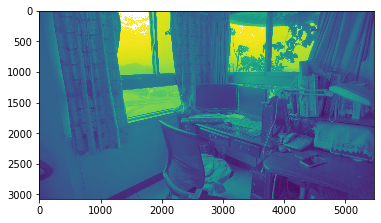

In [11]:
for c in range(channels):
    imshow(radiance_map[c])